In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../mnist-data/", one_hot=True)

Extracting ../mnist-data/train-images-idx3-ubyte.gz
Extracting ../mnist-data/train-labels-idx1-ubyte.gz
Extracting ../mnist-data/t10k-images-idx3-ubyte.gz
Extracting ../mnist-data/t10k-labels-idx1-ubyte.gz


In [4]:
mnist.train.images.shape

(55000, 784)

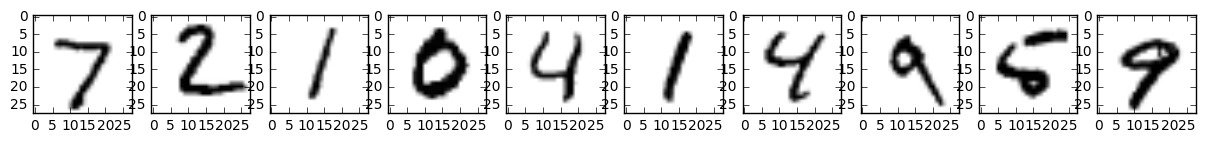

In [5]:
plt.figure(figsize=(15,5))
for i in list(range(10)):
    plt.subplot(1, 10, i+1)
    pixels = mnist.test.images[i]
    pixels = pixels.reshape((28, 28))
    plt.imshow(pixels, cmap='gray_r')
plt.show()

In [6]:
import tensorflow as tf

In [7]:
# Set parameters
learning_rate = 0.01
training_iteration = 10
batch_size = 250
print_freq=5

In [8]:
# TF graph input
x = tf.placeholder('float', [None, 784]) # mnist data image of shape 28*28=784
y = tf.placeholder('float', [None, 10]) # 0-9 digits recognition => 10 classes

keep_rate = tf.placeholder(tf.float32) 

In [9]:
def weight_variable(shape):
  initial = tf.constant(0.0, shape=shape)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

In [10]:
with tf.name_scope("hidden_1") as scope:

    # Set model weights
    W_layer1 = weight_variable([784, 512])
    b_layer1 = bias_variable([512])

    # Construct a dense linear model, with act=relu and dropout
    layer_1 = tf.nn.dropout(tf.nn.relu(tf.matmul(x, W_layer1) + b_layer1), keep_rate) # Relu, dropout
        
    # Add summary ops to collect data
    tf.histogram_summary("W1_weights", W_layer1)
    tf.histogram_summary("B1_biases", b_layer1)

In [11]:
with tf.name_scope("hidden_2") as scope:

    # Set model weights
    W_layer2 = weight_variable([512, 512])
    b_layer2 = bias_variable([512])

    # Construct a dense linear model, with act=relu and dropout
    layer_2 = tf.nn.dropout(tf.nn.relu(tf.matmul(layer_1, W_layer2) + b_layer2), keep_rate) # Relu, dropout
    
    # Add summary ops to collect data
    tf.histogram_summary("W2_weights", W_layer2)
    tf.histogram_summary("B2_biases", b_layer2)

In [12]:
with tf.name_scope("output") as scope:

    # Set model weights
    W_layer3 = weight_variable([512, 10])
    b_layer3 = bias_variable([10])

    # Construct a dense linear model, with act=relu and dropout
    layer_3 = tf.add(tf.matmul(layer_2, W_layer3), b_layer3)
    
    # Add summary ops to collect data
    tf.histogram_summary("W3_weights", W_layer3)
    tf.histogram_summary("B3_biases", b_layer3)

In [13]:
y_hat = layer_3

# More name scopes will clean up graph representation
with tf.name_scope("cost_function") as scope:
    # Minimize error using cross entropy
    # Cross entropy
    cost_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_hat,y))
    # Create a summary to monitor the cost function
    tf.scalar_summary("cost_function", cost_function)

In [14]:
with tf.name_scope("train") as scope:
    # Gradient descent
    optimizer = tf.train.AdamOptimizer().minimize(cost_function)

In [15]:
# Initializing the variables
init = tf.global_variables_initializer()

# Merge all summaries into a single operator
merged_summary_op = tf.merge_all_summaries()

In [16]:
# Launch the graph
sess = tf.InteractiveSession()
sess.run(init)

In [17]:
# Change this to a location on your computer
summary_writer = tf.train.SummaryWriter('./tensorboard', graph=sess.graph)

In [18]:
# Training cycle
for iteration in range(training_iteration):
    avg_cost = 0.
    total_batch = int(mnist.train.num_examples/batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        
        # dropout placeholder
        batch_kr = 0.50
        
        # Fit training using batch data
        sess.run(optimizer, feed_dict={x: batch_xs, keep_rate: batch_kr, y: batch_ys})
        
        # Compute the average loss
        avg_cost += sess.run(cost_function, feed_dict={x: batch_xs, keep_rate: batch_kr, y: batch_ys})/(total_batch+1)

        # Write logs for each iteration
        summary_str = sess.run(merged_summary_op, feed_dict={x: batch_xs, keep_rate:batch_kr, y: batch_ys})
        summary_writer.add_summary(summary_str, iteration*total_batch + i)
        
    # Display logs per iteration step
    if iteration % print_freq ==0 :
        print("Iteration:", '%04d' % (iteration), "cost=", "{:.9f}".format(avg_cost))


Iteration: 0000 cost= 0.636337465
Iteration: 0005 cost= 0.083090350


In [19]:
# Test the model
predictions = tf.equal(tf.argmax(y_hat, 1), tf.argmax(y, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(predictions, "float"))
print("Accuracy:", accuracy.eval({x: mnist.test.images, keep_rate:1.0, y: mnist.test.labels}))


Accuracy: 0.9802


In [20]:
# test item #100 is a six
pixels = mnist.test.images[100]

#predict
result = sess.run(y_hat, feed_dict={x:[pixels], keep_rate:1.0})
dict(zip(range(10), result[0]))

{0: -0.67221421,
 1: -1.1577997,
 2: -2.9426241,
 3: -7.9031072,
 4: -1.8667712,
 5: -0.85029024,
 6: 10.890368,
 7: -7.851676,
 8: -2.940767,
 9: -13.123693}

In [21]:
def test_render(pixels, result, truth):
    #pixels, result and truth are np vectors
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    pixels = pixels.reshape((28, 28))
    plt.imshow(pixels, cmap='gray_r')

    plt.subplot(1, 2, 2)
    
    #index, witdh
    ind = np.arange(len(result))
    width = 0.4

    plt.barh(ind,result, width, color='gray')
    plt.barh(ind+width,truth,width, color='green')
    plt.yticks(ind+width, range(10))
    plt.margins(y=0)

    plt.show()

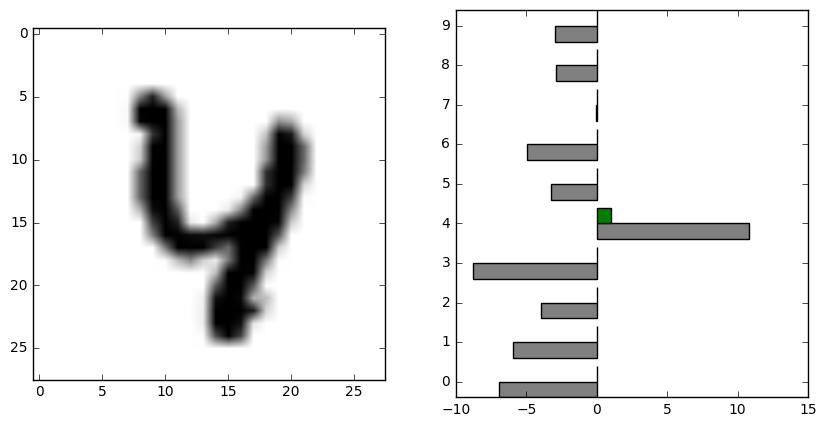

In [22]:
import random
i = random.randint(0,mnist.test.images.shape[0])

pixels = mnist.test.images[i]
truth  = mnist.test.labels[i]
result = sess.run(y_hat, feed_dict={x:[pixels], keep_rate:1.0})[0]

test_render(pixels, result, truth)

In [23]:
### What went wrong?
pixels = mnist.test.images
truth = mnist.test.labels

feed_dict = {x:pixels}
feed_dict.update({keep_rate:1.0})
result = sess.run(y_hat, feed_dict=feed_dict)

result

array([[ -5.49307871,  -3.05666542,   1.69230998, ...,  12.4670372 ,
         -6.89279032,  -3.37474895],
       [ -3.04950523,  -0.48373163,  11.4061718 , ..., -12.11981964,
         -7.21774578, -19.932827  ],
       [ -5.87495852,   9.60820484,  -1.75133145, ...,  -2.24002886,
         -1.71492517,  -8.18689156],
       ..., 
       [ -8.81000423,  -4.59461308,  -4.93855047, ...,   0.44103283,
         -1.95505059,  -1.00645792],
       [ -5.85191774,  -7.45354986, -10.83048153, ..., -10.51720619,
         -1.45325613,  -6.33881187],
       [ -2.01672053,  -6.34048796,  -2.53523636, ..., -18.56098557,
         -4.82092571, -13.10776424]], dtype=float32)

In [24]:
acc = result.argmax(axis=1) == truth.argmax(axis=1)
incorrect = np.argwhere(acc==False).flatten()

print("Incorrect predictions: {}".format(len(incorrect)))

Incorrect predictions: 198


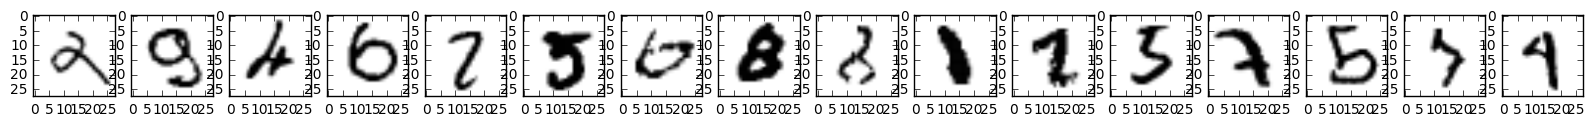

In [25]:
plt.figure(figsize=(20,5))
plt_idx = 1
for i in list(incorrect[:16]):
    plt.subplot(1, 16, plt_idx)
    pixels = mnist.test.images[i]
    pixels = pixels.reshape((28, 28))
    plt.imshow(pixels, cmap='gray_r')
    plt_idx += 1
plt.show()

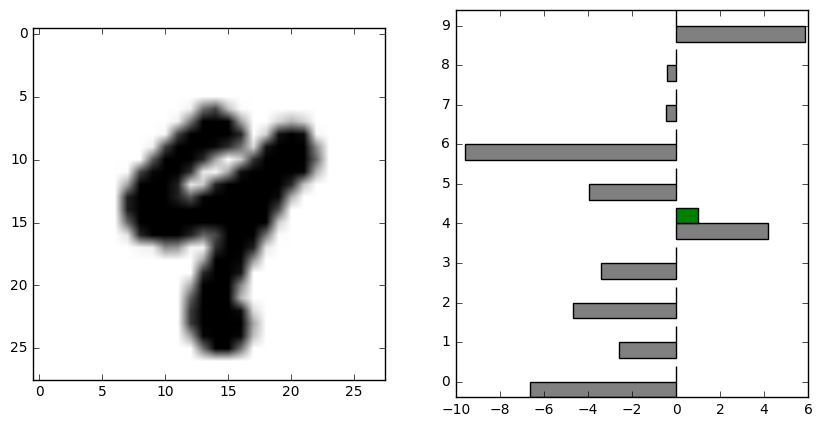

In [26]:
i = random.choice(list(incorrect))

pixels = mnist.test.images[i]
truth  = mnist.test.labels[i]

feed_dict = {x:[pixels]}
feed_dict.update({keep_rate:1.0})
result = sess.run(y_hat, feed_dict=feed_dict)[0]

test_render(pixels, result, truth)

In [27]:
# Close the Session when we're done.
# sess.close()